# 建立CNN
# 導入相關lib

In [1]:
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

Using TensorFlow backend.


# 建立圖片產生器

In [2]:
# image generator of trainning data
data_traingen = ImageDataGenerator(rescale=1/255,rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2)
train_gen = data_traingen.flow_from_directory(
'data/train',
target_size=(300,200),
batch_size=20,
class_mode='binary',
subset='training',
shuffle=True)

val_gen = data_traingen.flow_from_directory(
'data/train',
target_size=(300,200),
batch_size=20,
class_mode='binary',
subset='validation',
shuffle=True)

print(train_gen.class_indices)

Found 1458 images belonging to 4 classes.
Found 363 images belonging to 4 classes.
{'healthy': 0, 'multiple_diseases': 1, 'rust': 2, 'scab': 3}


# 建立CNN

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = ""

layer_list = [keras.layers.Conv2D(filters=50,kernel_size=(3,3),input_shape=(300,200,3),activation='relu'),
             keras.layers.Conv2D(filters=30,kernel_size=(3,3),activation='relu'),
             keras.layers.MaxPooling2D(pool_size=(2,2)),
             keras.layers.Conv2D(filters=15,kernel_size=(5,5),activation='relu'),
             keras.layers.MaxPooling2D(pool_size=(2,2)),
             keras.layers.Flatten(),
             keras.layers.Dense(50,activation='relu'),
             keras.layers.Dense(50,activation='relu'),
             keras.layers.Dense(4,activation='softmax')]

model = keras.Sequential(layer_list)
model.summary()
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 298, 198, 50)      1400      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 296, 196, 30)      13530     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 148, 98, 30)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 144, 94, 15)       11265     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 72, 47, 15)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 68, 43, 10)        3760      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 34, 21, 10)       

In [6]:
es = keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=5,restore_best_weights=True)
history = model.fit_generator(train_gen,
                              validation_data=val_gen,
                              epochs=50,
                              steps_per_epoch=1000,
                              callbacks=[es],
                              shuffle=True)

Epoch 1/50
1000/1000 [==============================] - 454s 454ms/step - loss: 0.2172 - accuracy: 0.9262 - val_loss: 0.0401 - val_accuracy: 0.9339
Epoch 2/50
1000/1000 [==============================] - 451s 451ms/step - loss: 0.2080 - accuracy: 0.9302 - val_loss: 0.4904 - val_accuracy: 0.9036
Epoch 3/50
1000/1000 [==============================] - 450s 450ms/step - loss: 0.1960 - accuracy: 0.9331 - val_loss: 1.1876 - val_accuracy: 0.8981
Epoch 4/50
1000/1000 [==============================] - 447s 447ms/step - loss: 0.1774 - accuracy: 0.9397 - val_loss: 0.0544 - val_accuracy: 0.9284
Epoch 5/50
1000/1000 [==============================] - 444s 444ms/step - loss: 0.1580 - accuracy: 0.9441 - val_loss: 0.0857 - val_accuracy: 0.8981
Epoch 6/50
1000/1000 [==============================] - 441s 441ms/step - loss: 0.1483 - accuracy: 0.9495 - val_loss: 0.7590 - val_accuracy: 0.8843


In [4]:
model.save('model.h5')
#model = keras.models.load_model('model.h5')

# 繪製learning curve

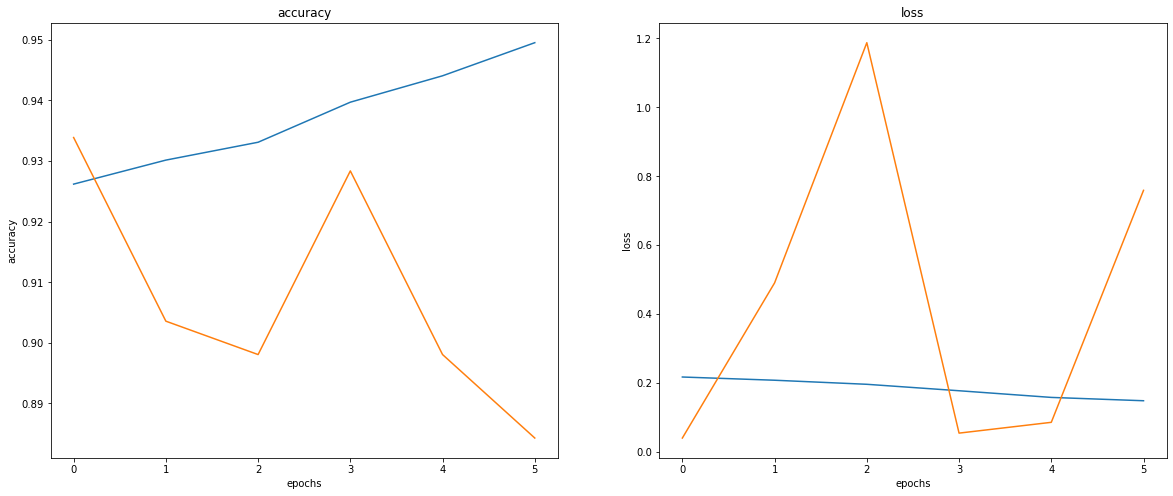

In [9]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'],label='acc')
plt.plot(history.history['val_accuracy'],label='val_acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy')
plt.subplot(1,2,2)
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss')
plt.show()

# 測試階段

In [10]:
test_data_list = os.listdir('data/test')
name_list = []
test_list = []
for i in range(len(test_data_list)):
    file_name = 'Test_%s'%(i)
    image = Image.open(os.path.join('data','test',file_name+'.jpg'))
    name_list.append(file_name)
    test_list.append(np.asarray(image.resize((200,300)))/255)

test_array = np.asarray(test_list)
pre = model.predict(test_array)



In [11]:
pre_df = pd.DataFrame(pre)
name_df = pd.DataFrame(name_list)
res = pd.concat([name_df,pre_df],axis=1)
res.columns = ['image_id','healthy','multiple_diseases','rust','scab']
res.head()
res.to_csv('res.csv',index=False)
